In [1]:
import torch
import os
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
from model.SRCNN_model import SRCNN
from model.SRGAN_model import Generator 
from src.data_loader import SRDataset 

def load_image(image_path):
    """
    Load an image from the specified path.

    Parameters:
    image_path (str): Path to the image file.

    Returns:
    numpy.ndarray: The loaded image in RGB format.
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def preprocess_image(image, target_size):
    """
    Preprocess the image for model input.

    Parameters:
    image (numpy.ndarray): The image to preprocess.
    target_size (tuple): The target size for resizing the image.

    Returns:
    torch.Tensor: Preprocessed image tensor.
    """
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
    return image.unsqueeze(0)

def postprocess_image(image):
    """
    Postprocess the model output to convert it back to an image.

    Parameters:
    image (torch.Tensor): The image tensor output by the model.

    Returns:
    numpy.ndarray: Postprocessed image suitable for display.
    """
    image = image.squeeze().permute(1, 2, 0).numpy() * 255.0
    image = image.clip(0, 255).astype('uint8')
    return image

def load_model(model_class, model_path, device):
    """
    Load a model from the specified path.

    Parameters:
    model_class (class): The class of the model to load.
    model_path (str): Path to the model weights file.
    device (torch.device): The device to load the model onto.

    Returns:
    torch.nn.Module: The loaded model.
    """
    model = model_class().to(device)
    model = nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model


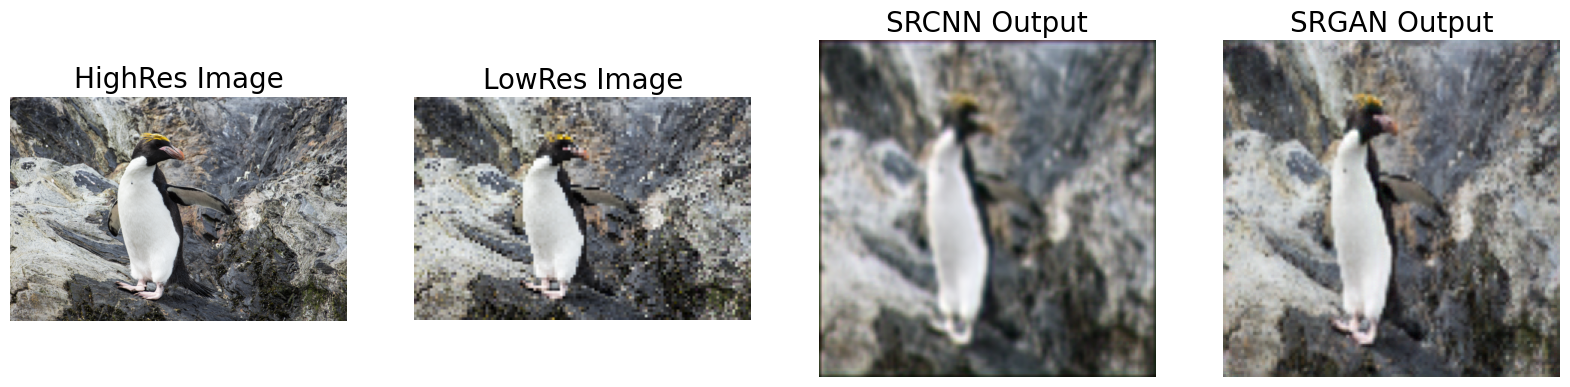

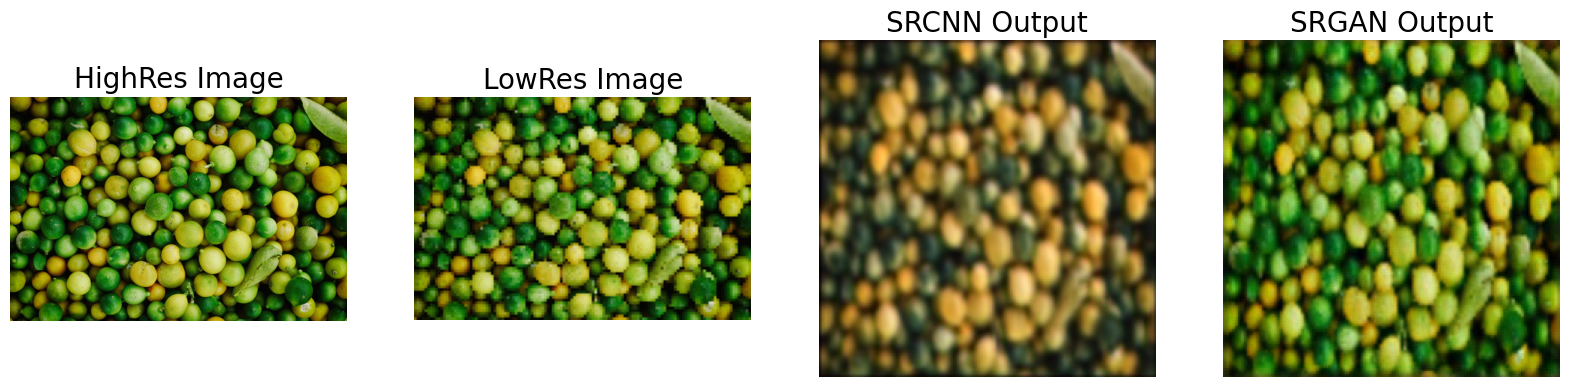

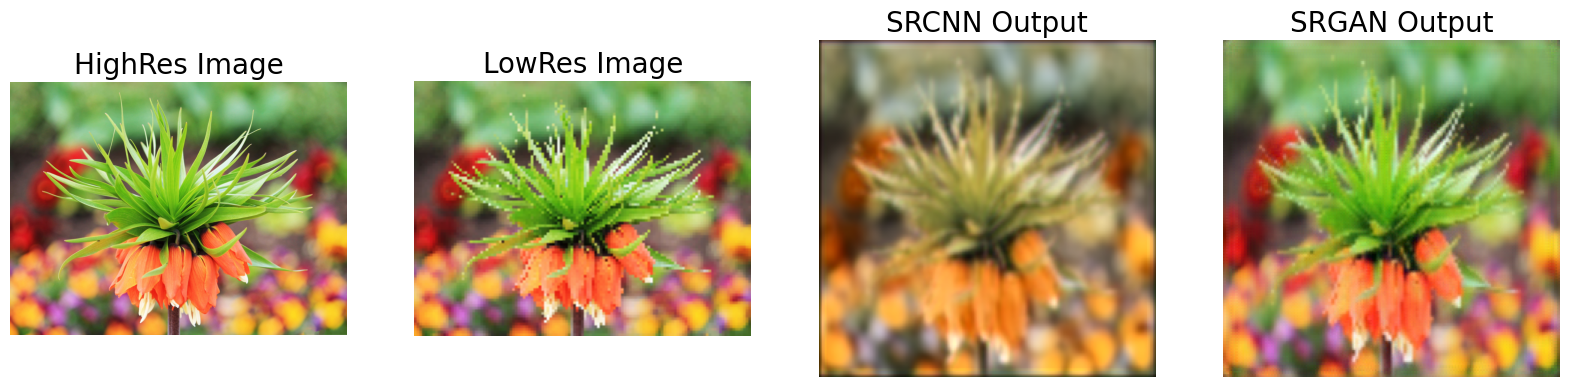

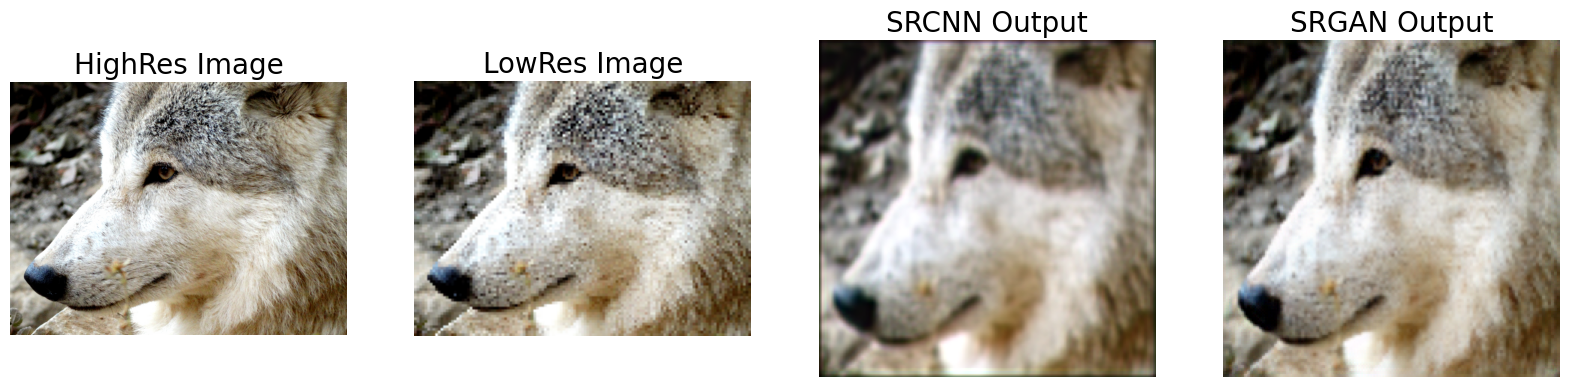

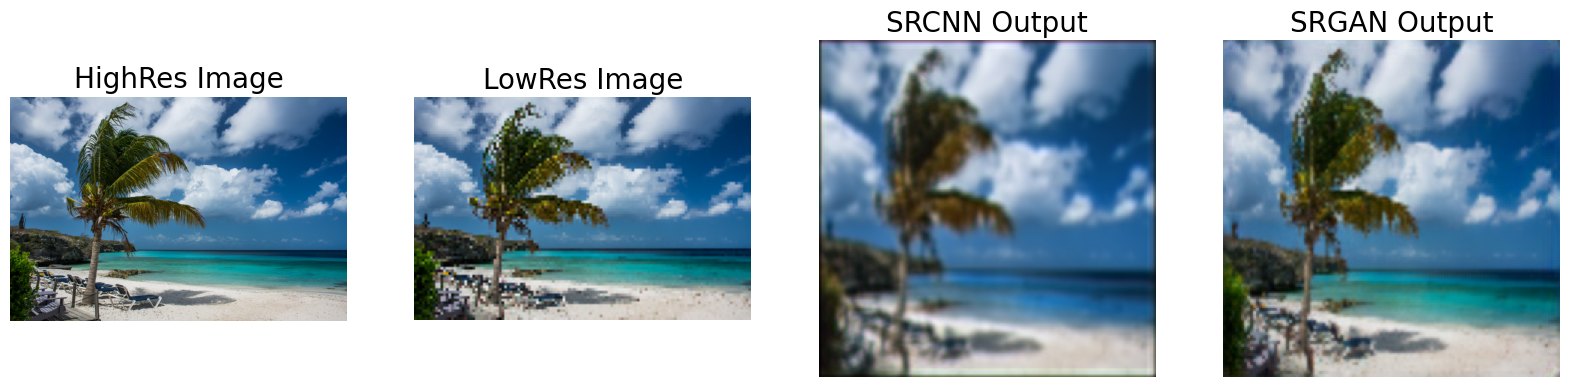

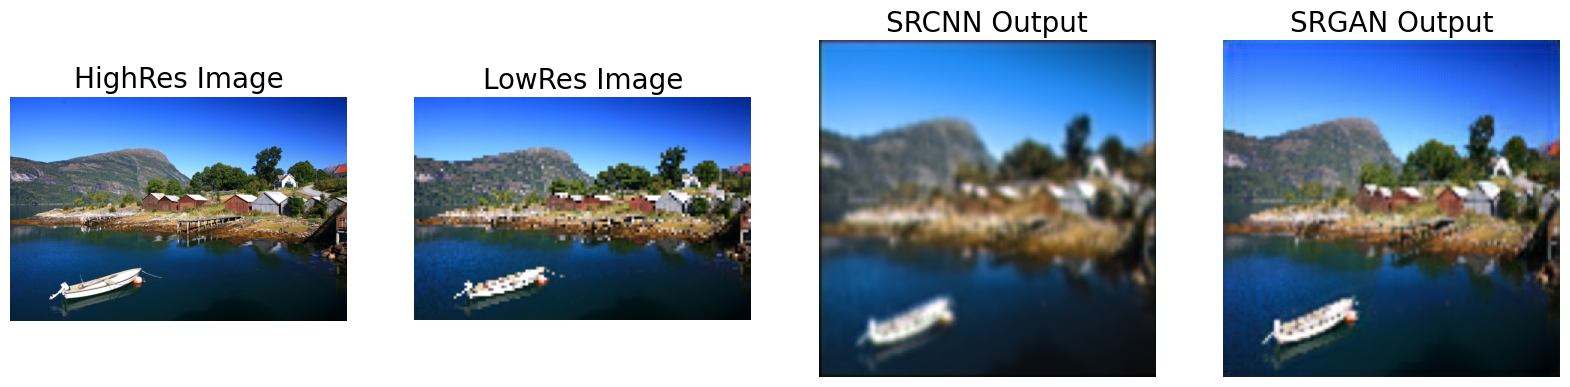

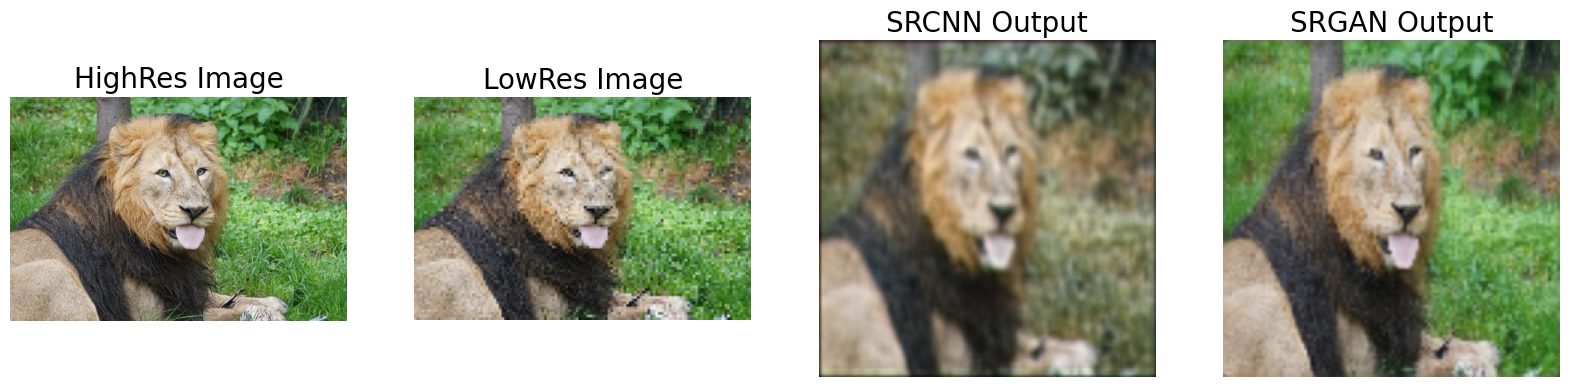

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best models
srcnn = load_model(SRCNN, "output/saved_model_srcnn/best_model_epoch_63.pth", device)
srgan = load_model(Generator, "../output/saved_model_srcnn/best_generator_69.pth", device)

# Image file paths
hr_image_paths = [f"data/DIV2K_test_HR/080{i}.png" for i in range(1, 10)]
lr_image_paths = [f"data/DIV2K_test_LR_bicubic/X2/080{i}x2.png" for i in range(1, 10)]


# Iterate through each set of images
for idx, (hr_path, lr_path) in enumerate(zip(hr_image_paths, lr_image_paths)):
    # Load and preprocess images
    high_res_image = load_image(hr_path)
    low_res_image = load_image(lr_path)
    low_res_preprocessed = preprocess_image(low_res_image, (112, 112)).to(device)

    # Generate super-resolution images
    with torch.no_grad():
        srcnn_pred = postprocess_image(srcnn(low_res_preprocessed).cpu())
        srgan_pred = postprocess_image(srgan(low_res_preprocessed).cpu())

    # Display images
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
    axes[0].imshow(high_res_image)
    axes[0].set_title("HighRes Image", fontsize=20)
    axes[0].axis('off')
    
    axes[1].imshow(low_res_image)
    axes[1].set_title("LowRes Image", fontsize=20)
    axes[1].axis('off')

    axes[2].imshow(srcnn_pred)
    axes[2].set_title("SRCNN Output", fontsize=20)
    axes[2].axis('off')

    axes[3].imshow(srgan_pred)
    axes[3].set_title("SRGAN Output", fontsize=20)
    axes[3].axis('off')
    fig.savefig(os.path.join("output/images", f"output{idx+1}.png"), bbox_inches='tight')
    plt.show()